In [1]:
import tensorflow as tf
import numpy as np
import import_ipynb

from tensorflow import keras
from keras.models import load_model
from dataset_prep import *
from scipy import signal


Using TensorFlow backend.


importing Jupyter notebook from dataset_prep.ipynb
Number of images: 324


In [2]:
class LUNET:
    def __init__(self, image_size):
        self.image_size = image_size
        self.model = self.UNet()
    
    def down_block(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
        return c, p

    def up_block(self, x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
        us = keras.layers.UpSampling2D((2, 2))(x)
        concat = keras.layers.Concatenate()([us, skip])
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        return c

    def bottleneck(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        return c
    
    def UNet(self):
        f = [8, 16, 32, 64, 128, 256]
        inputs = keras.layers.Input((self.image_size, self.image_size, 3))

        p0 = inputs
        #c0, p0 = self.down_block(p00, f[0]) #256 -> 128
        c1, p1 = self.down_block(p0, f[1]) #128 -> 64
        c2, p2 = self.down_block(p1, f[2]) #64 -> 32
        c3, p3 = self.down_block(p2, f[3]) #32 -> 16
        c4, p4 = self.down_block(p3, f[4]) #16->8

        bn = self.bottleneck(p4, f[5])

        u1 = self.up_block(bn, c4, f[4]) #8 -> 16
        u2 = self.up_block(u1, c3, f[3]) #16 -> 32
        u3 = self.up_block(u2, c2, f[2]) #32 -> 64
        u4 = self.up_block(u3, c1, f[1]) #64 -> 128
        #u5 = self.up_block(u4, c0, f[0]) #128 -> 256
        
        outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
        model = keras.models.Model(inputs, outputs)
        return model

In [3]:
parameters_file = "/Users/denyskononenko/Documents/build_proc/saved_models/UNet-params-300-epochs-new-data.h5"
model_file = "/Users/denyskononenko/Documents/build_proc/saved_models/lunet-model-300-epochs.h5"
# hyperparameters
epochs = 300
image_size = 128
batch_size = 8
val_datasize = 10

# indices of train images and validation images
train_ids = image_ids[val_datasize:]
valid_ids = image_ids[:val_datasize]


train_gen = DataGenerator(train_ids, PATH_TO_BUILDINGS_TRAININSET, image_size=image_size, batch_size=batch_size)
valid_gen = DataGenerator(valid_ids, PATH_TO_BUILDINGS_TRAININSET, image_size=image_size, batch_size=batch_size)

In [ ]:
print(image_ids)

In [4]:
lunet = LUNET(image_size)
model = lunet.model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

(8, 128, 128, 3) (8, 128, 128, 1)


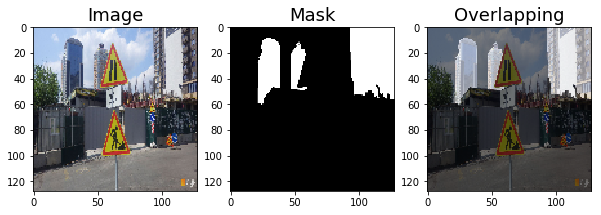

In [6]:
data_gen = DataGenerator(image_ids, PATH_TO_BUILDINGS_TRAININSET)
x, y = data_gen.__getitem__(1)
print(x.shape, y.shape)
DataGenerator.show_img_mask(x[7], y[7])

In [7]:
train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

# train model
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)


Epoch 1/300
39/39 [==============================] - 49s 1s/step - loss: 5.0151 - acc: 0.6521 - val_loss: 4.3794 - val_acc: 0.7463
Epoch 2/300
39/39 [==============================] - 47s 1s/step - loss: 4.0676 - acc: 0.7590 - val_loss: 4.3549 - val_acc: 0.7374
Epoch 3/300
39/39 [==============================] - 45s 1s/step - loss: 3.7356 - acc: 0.7691 - val_loss: 3.4025 - val_acc: 0.7788
Epoch 4/300
39/39 [==============================] - 45s 1s/step - loss: 3.2690 - acc: 0.8006 - val_loss: 2.8748 - val_acc: 0.8429
Epoch 5/300
39/39 [==============================] - 45s 1s/step - loss: 3.2513 - acc: 0.8051 - val_loss: 3.3925 - val_acc: 0.8090
Epoch 6/300
39/39 [==============================] - 47s 1s/step - loss: 3.0837 - acc: 0.8215 - val_loss: 2.8290 - val_acc: 0.8399
Epoch 7/300
39/39 [==============================] - 44s 1s/step - loss: 2.9345 - acc: 0.8349 - val_loss: 2.8445 - val_acc: 0.8178
Epoch 8/300
39/39 [==============================] - 220s 6s/step - loss: 2.9723 - 

39/39 [==============================] - 40s 1s/step - loss: 0.2914 - acc: 0.9792 - val_loss: 3.0570 - val_acc: 0.8917
Epoch 64/300
39/39 [==============================] - 40s 1s/step - loss: 0.3006 - acc: 0.9785 - val_loss: 4.0743 - val_acc: 0.8781
Epoch 65/300
39/39 [==============================] - 40s 1s/step - loss: 0.3190 - acc: 0.9765 - val_loss: 3.7174 - val_acc: 0.8820
Epoch 66/300
39/39 [==============================] - 43s 1s/step - loss: 0.2960 - acc: 0.9790 - val_loss: 3.2786 - val_acc: 0.8927
Epoch 67/300
39/39 [==============================] - 43s 1s/step - loss: 0.2910 - acc: 0.9781 - val_loss: 3.8629 - val_acc: 0.8848
Epoch 68/300
39/39 [==============================] - 50s 1s/step - loss: 0.2854 - acc: 0.9799 - val_loss: 3.7852 - val_acc: 0.8835
Epoch 69/300
39/39 [==============================] - 58s 1s/step - loss: 0.2879 - acc: 0.9785 - val_loss: 3.6298 - val_acc: 0.8846
Epoch 70/300
39/39 [==============================] - 48s 1s/step - loss: 0.2606 - acc: 0

Epoch 125/300
39/39 [==============================] - 53s 1s/step - loss: 0.1790 - acc: 0.9835 - val_loss: 5.5926 - val_acc: 0.8823
Epoch 126/300
39/39 [==============================] - 45s 1s/step - loss: 0.1746 - acc: 0.9845 - val_loss: 5.3925 - val_acc: 0.8831
Epoch 127/300
39/39 [==============================] - 43s 1s/step - loss: 0.1837 - acc: 0.9836 - val_loss: 4.5240 - val_acc: 0.8883
Epoch 128/300
39/39 [==============================] - 45s 1s/step - loss: 0.1757 - acc: 0.9844 - val_loss: 5.2843 - val_acc: 0.8824
Epoch 129/300
39/39 [==============================] - 47s 1s/step - loss: 0.1808 - acc: 0.9839 - val_loss: 5.0708 - val_acc: 0.8852
Epoch 130/300
39/39 [==============================] - 53s 1s/step - loss: 0.1673 - acc: 0.9843 - val_loss: 5.3682 - val_acc: 0.8848
Epoch 131/300
39/39 [==============================] - 59s 2s/step - loss: 0.1598 - acc: 0.9850 - val_loss: 4.9460 - val_acc: 0.8880
Epoch 132/300
39/39 [==============================] - 54s 1s/step - 

39/39 [==============================] - 59s 2s/step - loss: 0.1616 - acc: 0.9852 - val_loss: 4.3033 - val_acc: 0.8952
Epoch 187/300
39/39 [==============================] - 49s 1s/step - loss: 0.1656 - acc: 0.9844 - val_loss: 4.6251 - val_acc: 0.8934
Epoch 188/300
39/39 [==============================] - 46s 1s/step - loss: 0.1590 - acc: 0.9853 - val_loss: 3.9338 - val_acc: 0.8980
Epoch 189/300
39/39 [==============================] - 49s 1s/step - loss: 0.1550 - acc: 0.9849 - val_loss: 4.2952 - val_acc: 0.8975
Epoch 190/300
39/39 [==============================] - 49s 1s/step - loss: 0.1633 - acc: 0.9844 - val_loss: 4.7378 - val_acc: 0.8914
Epoch 191/300
39/39 [==============================] - 45s 1s/step - loss: 0.1558 - acc: 0.9858 - val_loss: 4.3494 - val_acc: 0.8998
Epoch 192/300
39/39 [==============================] - 47s 1s/step - loss: 0.1614 - acc: 0.9844 - val_loss: 4.5652 - val_acc: 0.8953
Epoch 193/300
39/39 [==============================] - 46s 1s/step - loss: 0.1483 -

Epoch 248/300
39/39 [==============================] - 52s 1s/step - loss: 0.2654 - acc: 0.9803 - val_loss: 3.2143 - val_acc: 0.8979
Epoch 249/300
39/39 [==============================] - 48s 1s/step - loss: 0.2276 - acc: 0.9823 - val_loss: 3.2009 - val_acc: 0.8980
Epoch 250/300
39/39 [==============================] - 47s 1s/step - loss: 0.2298 - acc: 0.9821 - val_loss: 3.6178 - val_acc: 0.8943
Epoch 251/300
39/39 [==============================] - 44s 1s/step - loss: 0.2040 - acc: 0.9831 - val_loss: 3.6883 - val_acc: 0.8969
Epoch 252/300
39/39 [==============================] - 48s 1s/step - loss: 0.2066 - acc: 0.9832 - val_loss: 3.6587 - val_acc: 0.8974
Epoch 253/300
39/39 [==============================] - 47s 1s/step - loss: 0.1847 - acc: 0.9842 - val_loss: 3.7986 - val_acc: 0.8964
Epoch 254/300
39/39 [==============================] - 48s 1s/step - loss: 0.1795 - acc: 0.9843 - val_loss: 3.9261 - val_acc: 0.8965
Epoch 255/300
39/39 [==============================] - 46s 1s/step - 

In [8]:
## Save the Weights and model 
model.save(model_file)
model.save_weights(parameters_file)

## Dataset for prediction
x, y = valid_gen.__getitem__(0)
result = model.predict(x) 

result = result > 0.5

In [9]:
def display_valid_imgs(img, background, result, image_size=128):
    """
    Display init image, background truth and prediction of NN
    """
    plt.figure(figsize=(10, 10))
    
    plt.subplot(131)
    plt.title("init image", fontsize=18)
    plt.imshow(img)
        
    plt.subplot(132)
    plt.title("Background truth", fontsize=18)
    plt.imshow(np.reshape(background, (image_size, image_size)), cmap="gray")
        
    plt.subplot(133)
    plt.title("Result", fontsize=18)
    plt.imshow(np.reshape(result, (image_size, image_size)), cmap="gray")
    
def display_test_imgs(img1, result1, img2, result2, image_size=128):
    """12
    Display init image, background truth and prediction of NN for image pairs
    """
    plt.figure(figsize=(20, 20))
    
    plt.subplot(141)
    plt.title("init image 1", fontsize=18)
    plt.imshow(img1)
        
    plt.subplot(142)
    plt.title("result 1", fontsize=18)
    plt.imshow(np.reshape(result1, (image_size, image_size)), cmap="gray")
        
    plt.subplot(143)
    plt.title("init image 2", fontsize=18)
    plt.imshow(img2)
    
    plt.subplot(144)
    plt.title("result 2", fontsize=18)
    plt.imshow(np.reshape(result2, (image_size, image_size)), cmap="gray")
    

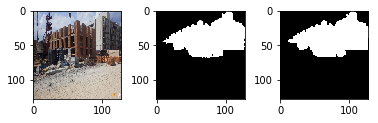

In [10]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[2])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[2]*255, (image_size, image_size)), cmap="gray")

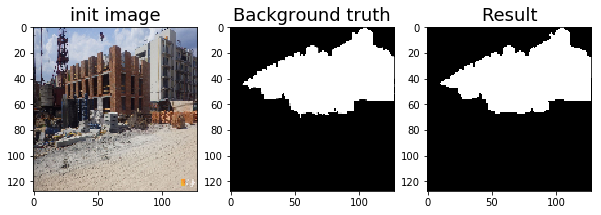

In [11]:
display_valid_imgs(x[2], y[2], result[2])

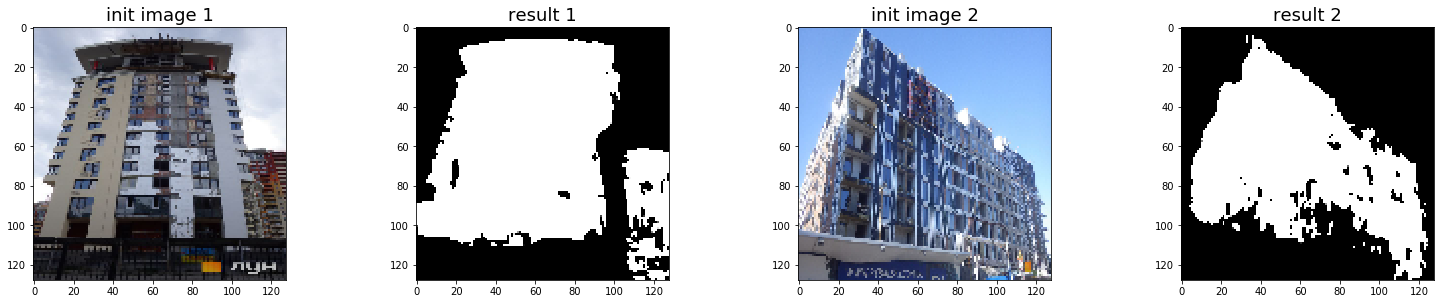

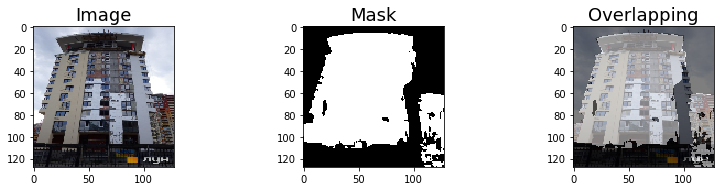

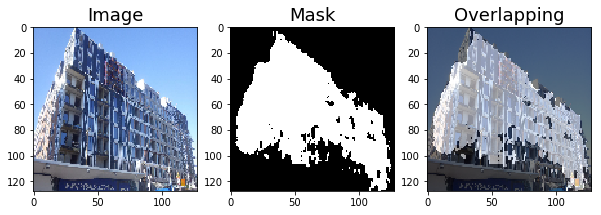

In [12]:
test_images = ["https://img.lun.ua/construction-1600x900/220857.jpg", "https://img.lun.ua/construction-1600x900/179470.jpg", "https://img.lun.ua/construction-1600x900/236157.jpg", "https://img.lun.ua/construction-1600x900/235463.jpg", "https://img.lun.ua/construction-1600x900/230669.jpg", "https://img.lun.ua/construction-1600x900/235462.jpg", "https://img.lun.ua/construction-1600x900/67081.jpg", "https://img.lun.ua/construction-1600x900/49734.jpg", "https://img.lun.ua/construction-1600x900/236483.jpg", "https://img.lun.ua/construction-1600x900/232905.jpg", "https://img.lun.ua/construction-1600x900/140392.jpg", "https://img.lun.ua/construction-1600x900/203614.jpg", "https://img.lun.ua/panorama/1983-3-24.jpg"]

test_img1 = cv2.resize(DataGenerator.read_img(test_images[-6]), (128, 128))
test_img2 = cv2.resize(DataGenerator.read_img(test_images[-5]), (128, 128))

res1 = model.predict(np.array([test_img1]))
res2 = model.predict(np.array([test_img2]))

display_test_imgs(test_img1, res1, test_img2, res2)


DataGenerator.show_img_mask(test_img1, res1)
DataGenerator.show_img_mask(test_img2, res2)


In [ ]:
def matcher(msk1, msk2):
    """
    Optimal shape matcher
    @param mask1 binary image mask
    @param mask2 binary image mask
    """
    resgr1 = np.uint8(np.reshape(msk1, (128, 128)))
    resgr2 = np.uint8(np.reshape(msk2, (128, 128)))
    
    canny1 = 255 - cv2.Canny(resgr1, 0, 0)
    canny2 = 255 - cv2.Canny(resgr2, 0, 0)
    
    #display both contours
    plt.imshow(canny1, cmap="gray")
    plt.imshow(canny2, alpha=0.5) 
    
    sift = cv2.xfeatures2d.SIFT_create();
    kp_base, desc_base = sift.detectAndCompute(canny1, None)
    kp, desc = sift.detectAndCompute(canny2, None)
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch( desc, desc_base,  k=2 )
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.95*n.distance:
            good.append([m])
    
    features_12 = [len(kp_base), len(kp)]
    similarity = 100 * len(good) / len(matches)
    
    print("similarity: {}".format(similarity))
    print("matches {}".format(len(matches)))
    print("let kp1 {}, let descr1 {}".format(len(kp), len(desc)))
    print("let kp {}, let descr {}".format(len(kp_base), len(desc_base)))
    return float('{0:.2f}'.format(similarity))



In [ ]:
# load model coefitients
model2 = keras.models.load_model(model_file)
model2.load_weights(parameters_file)

In [ ]:
test_images = ["https://img.lun.ua/construction-1600x900/220857.jpg", "https://img.lun.ua/construction-1600x900/179470.jpg", "https://img.lun.ua/construction-1600x900/236157.jpg", "https://img.lun.ua/construction-1600x900/235463.jpg", "https://img.lun.ua/construction-1600x900/230669.jpg", "https://img.lun.ua/construction-1600x900/235462.jpg", "https://img.lun.ua/construction-1600x900/67081.jpg", "https://img.lun.ua/construction-1600x900/49734.jpg", "https://img.lun.ua/construction-1600x900/236483.jpg", "https://img.lun.ua/construction-1600x900/232905.jpg", "https://img.lun.ua/construction-1600x900/140392.jpg", "https://img.lun.ua/construction-1600x900/203614.jpg", "https://img.lun.ua/panorama/1983-3-24.jpg"]

test_img1 = cv2.resize(DataGenerator.read_img(test_images[-7]), (128, 128))
test_img2 = cv2.resize(DataGenerator.read_img(test_images[-6]), (128, 128))

res1 = model2.predict(np.array([test_img1]))
res2 = model2.predict(np.array([test_img2]))

display_test_imgs(test_img1, res1, test_img2, res2)

In [ ]:
matcher(res1, res2) 